In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from utils import load_mnist
from trainer import Trainer

In [4]:
def show_image(x):
    if x.dim()==1:
        x=x.view(int(x.size(0)**.5), -1)
        
    plt.imshow(x, cmap='gray')
    plt.show()

### config 지정

In [5]:
from argparse import Namespace

config={
    'train_ratio':.8,
    'batch_size' :256,
    'n_epochs':10,
    'verbose':1,
    'btl_size':2
}
#참고로 최적의 btl_size는 10~20이어서 2로 설정했을 때는 너무 많이 압축한 것이 됨

config=Namespace(**config) #마치 argumentparser를 통과한 것처럼 만들기 위해 씀

print(config)

Namespace(batch_size=256, btl_size=2, n_epochs=10, train_ratio=0.8, verbose=1)


### 1강의 train.py에서의 작동과 유사

In [6]:
#train, test set 분리하기
train_x, train_y=load_mnist(flatten=True)
test_x, test_y=load_mnist(is_train=False, flatten=True)

#train, valid 개수 설정
train_cnt=int(train_x.size(0)*config.train_ratio)
valid_cnt=train_x.size(0)-train_cnt

#Shuffle dataset to split into train/valid set
indices=torch.randperm(train_x.size(0))
train_x, valid_x=torch.index_select(train_x, dim=0, index=indices).split([train_cnt, valid_cnt], dim=0)
train_y, valid_y=torch.index_select(train_y, dim=0, index=indices).split([train_cnt, valid_cnt], dim=0)

print("Train :", train_x.shape, train_y.shape)
print(train_cnt)
print("Valid :", valid_x.shape, valid_y.shape)
print(valid_cnt)
print("Test :", test_x.shape, test_y.shape)


Train : torch.Size([48000, 784]) torch.Size([48000])
48000
Valid : torch.Size([12000, 784]) torch.Size([12000])
12000
Test : torch.Size([10000, 784]) torch.Size([10000])


### Train, valid

In [7]:
from model import Autoencoder

In [8]:
model= Autoencoder(btl_size=config.btl_size)
optimizer=optim.Adam(model.parameters())
crit=nn.MSELoss()

trainer=Trainer(model, optimizer, crit)

In [9]:
trainer.train((train_x, train_x), (valid_x, valid_x), config) #Autoencoder이기 때문에 자기자신이 나옴, 따라서 y를 쓰지 않음

Epoch(1/10): train_loss=7.0049e-02  valid_loss=4.7940e-02  lowest_loss=4.7940e-02
Epoch(2/10): train_loss=4.6534e-02  valid_loss=4.4210e-02  lowest_loss=4.4210e-02
Epoch(3/10): train_loss=4.4299e-02  valid_loss=4.2543e-02  lowest_loss=4.2543e-02
Epoch(4/10): train_loss=4.3293e-02  valid_loss=4.2765e-02  lowest_loss=4.2543e-02
Epoch(5/10): train_loss=4.2361e-02  valid_loss=4.0664e-02  lowest_loss=4.0664e-02
Epoch(6/10): train_loss=4.1458e-02  valid_loss=4.0077e-02  lowest_loss=4.0077e-02
Epoch(7/10): train_loss=4.1215e-02  valid_loss=4.0081e-02  lowest_loss=4.0077e-02
Epoch(8/10): train_loss=4.0911e-02  valid_loss=4.0061e-02  lowest_loss=4.0061e-02
Epoch(9/10): train_loss=4.0730e-02  valid_loss=4.0276e-02  lowest_loss=4.0061e-02
Epoch(10/10): train_loss=4.0207e-02  valid_loss=3.9694e-02  lowest_loss=3.9694e-02


### Test

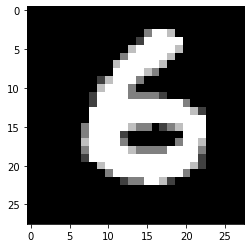

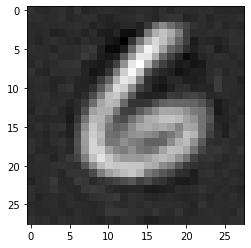

In [10]:
with torch.no_grad():
    import random

    index = int(random.random() * test_x.size(0))

    recon = model(test_x[index].view(1, -1)).squeeze()

    show_image(test_x[index])
    show_image(recon)

In [11]:
 int(random.random() * test_x.size(0))

4684

In [12]:
random.random()

0.9764675974775424

In [13]:
test_x[5732].shape

torch.Size([784])

In [14]:
test_x[5732].view(1,-1).shape

torch.Size([1, 784])

In [15]:
model(test_x[index].view(1, -1)).shape

torch.Size([1, 784])

In [16]:
recon.shape

torch.Size([784])

### Latent Space
encoder의 output이자 decoder의 input으로 bottleneck에서 존재하는 벡터의 벡터공간  
(N, 28*28)차원의 입력을 (N, 2) 차원으로 투사/압축 시킴

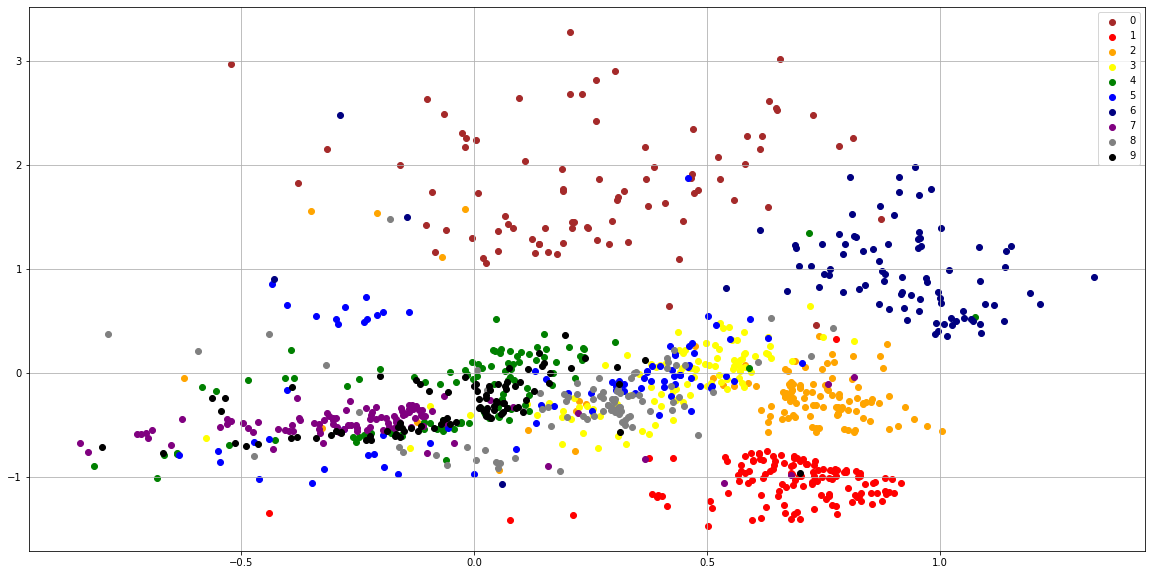

In [17]:
if config.btl_size==2:
    color_map=[
        'brown', 'red', 'orange', 'yellow', 'green',
        'blue', 'navy', 'purple', 'gray', 'black'
    ]
    
    plt.figure(figsize=(20,10))
    with torch.no_grad():
        latents=model.encoder(test_x[:1000])
        
        for i in range(10):
            target_latents=latents[test_y[:1000]==i]
            target_y=test_y[:1000][test_y[:1000]==i]
            plt.scatter(target_latents[:,0],
                       target_latents[:,1],
                       marker='o',
                       color=color_map[i],
                       label=i)
        plt.legend()
        plt.grid(axis='both')
        plt.show()

### latent space의 빈 공간에 대해서 어떤 값이 나오는지 확인해보기
latent space가 어떤 특징을 가는지 조금 이해해 볼 수 있음

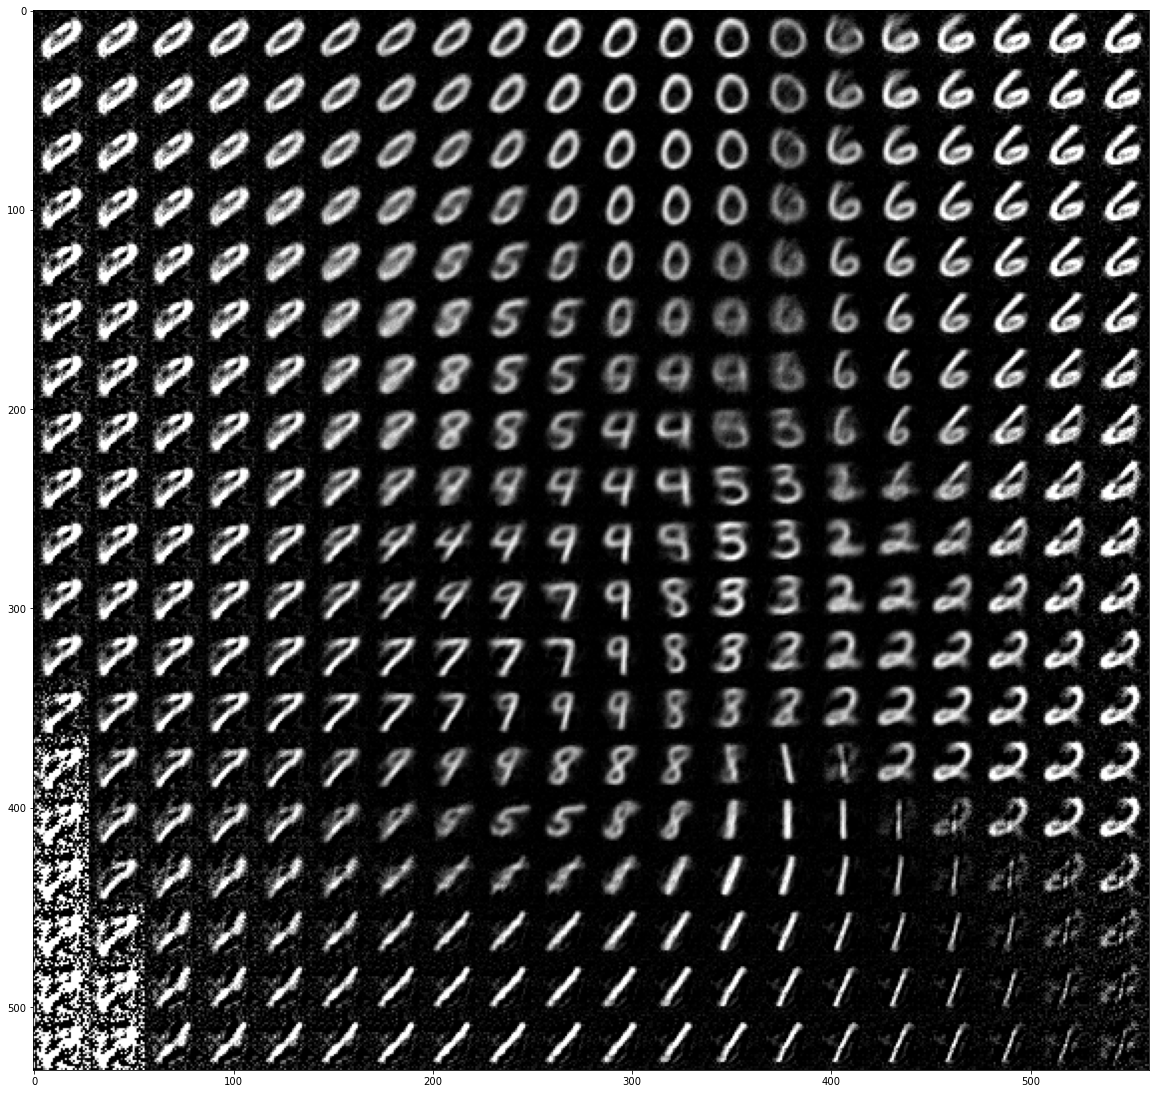

In [18]:
if config.btl_size == 2:
    min_range, max_range = -2., 2.
    n = 20
    step = (max_range - min_range) / float(n)
    
    with torch.no_grad():
        lines = []

        for v1 in np.arange(min_range, max_range, step):
            z = torch.stack([
                torch.FloatTensor([v1] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range,
                                                          max_range, step)]),
            ], dim=-1)
            
            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[i] for i in range(n - 1, 0, -1)], dim=0)
            lines += [line]
            
        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20, 20))
        show_image(lines)